# Statistical Learning and Deep Learning HW3



### Q1

#### Q1.1

1. Read the dataset.

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing

df = pd.read_csv('./ds/namesex_data_v2.csv', sep=',')
print(df.head())

  gname  sex  fold
0    承憲    1     9
1    均平    1     7
2    思安    0     6
3    佑誠    1     3
4    乃馨    0     0


2. Split the dataset into training, validation, stack, and test.

In [2]:
# split by fold value
train = df[df['fold'] <= 6]
valid = df[df['fold'] == 7]
stack = df[df['fold'] == 8]
test = df[df['fold'] == 9]
    
train = train.reset_index()
valid = valid.reset_index()
stack = stack.reset_index()
test = test.reset_index()

# split x, y
x_train = train['gname']
y_train = train['sex'].to_numpy()
x_valid = valid['gname']
y_valid = valid['sex'].to_numpy()
x_stack = stack['gname']
y_stack = stack['sex'].to_numpy()
x_test = test['gname']
y_test = test['sex'].to_numpy()

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_valid: {x_valid.shape}, y_valid: {y_valid.shape}')
print(f'x_stack: {x_stack.shape}, y_stack: {y_stack.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (7483,), y_train: (7483,)
x_valid: (1110,), y_valid: (1110,)
x_stack: (1073,), y_stack: (1073,)
x_test: (1064,), y_test: (1064,)


3. Apply one-hot encoding.

In [3]:
feature = list()
for name in list(x_train.to_numpy()):
    if len(name) > 1:
        feature += list(name)
    feature.append(name)
feature_set = set(feature) - set(' ')
feature_count = dict((f, feature.count(f)) for f in feature_set)
feature_count = dict(filter(lambda pair: pair[1] >= 2, feature_count.items()))
feature = list(feature_count.keys())
feature.append('_Other_Feature_')
print(f'# of feature: {len(feature)}')

# of feature: 1630


In [4]:
def oneHot(df):
    one_hot = pd.DataFrame(0, index=np.arange(df.shape[0]), columns=feature)
    for idx in range(df.shape[0]):
        # create feature list
        f_list = list(df[idx])
        if len(df[idx]) > 1:
            f_list.append(df[idx])
        cnt = 0
        # label
        for f in f_list:
            if f in feature:
                one_hot[f][idx] = 1
                cnt += 1
        # label other feature
        if cnt < len(f_list):
            one_hot['_Other_Feature_'][idx] = 1
    return one_hot, one_hot.columns

x_train, x_train_col = oneHot(x_train)
x_valid, x_valid_col = oneHot(x_valid)
x_stack, x_stack_col = oneHot(x_stack)
x_test, x_test_col = oneHot(x_test)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_valid: {x_valid.shape}, y_valid: {y_valid.shape}')
print(f'x_stack: {x_stack.shape}, y_stack: {y_stack.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (7483, 1630), y_train: (7483,)
x_valid: (1110, 1630), y_valid: (1110,)
x_stack: (1073, 1630), y_stack: (1073,)
x_test: (1064, 1630), y_test: (1064,)


#### Q1.2



In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# tune coefficient c
c_coef = np.geomspace(0.0001, 1000, num=20)
print(f'tune c from {c_coef}')

best_c = 0.0001
best_f1 = -np.inf
for c in c_coef:
    clf = LogisticRegression(C=c, max_iter=1000).fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)
    print(f'c: {c}, f1 score: {f1}')
    
    if f1 > best_f1:
        best_c = c
        best_f1 = f1
print(f'best c: {best_c}')
print(f'best f1: {best_f1}')

tune c from [1.00000000e-04 2.33572147e-04 5.45559478e-04 1.27427499e-03
 2.97635144e-03 6.95192796e-03 1.62377674e-02 3.79269019e-02
 8.85866790e-02 2.06913808e-01 4.83293024e-01 1.12883789e+00
 2.63665090e+00 6.15848211e+00 1.43844989e+01 3.35981829e+01
 7.84759970e+01 1.83298071e+02 4.28133240e+02 1.00000000e+03]
c: 0.0001, f1 score: 0.0
c: 0.00023357214690901214, f1 score: 0.0
c: 0.000545559478116852, f1 score: 0.007532956685499058
c: 0.0012742749857031334, f1 score: 0.3879699248120301
c: 0.002976351441631319, f1 score: 0.7491785323110624
c: 0.0069519279617756054, f1 score: 0.8430232558139534
c: 0.01623776739188721, f1 score: 0.8638941398865785
c: 0.0379269019073225, f1 score: 0.876763875823142
c: 0.08858667904100823, f1 score: 0.887841658812441
c: 0.2069138081114788, f1 score: 0.8895184135977338
c: 0.4832930238571752, f1 score: 0.8932955618508026
c: 1.1288378916846884, f1 score: 0.8945386064030133
c: 2.6366508987303554, f1 score: 0.8953817153628653
c: 6.1584821106602545, f1 score:

In [6]:
# train
x_train_valid = np.concatenate((x_train, x_valid), axis=0)
y_train_valid = np.concatenate((y_train, y_valid), axis=0)
clf_log = LogisticRegression(C=best_c, max_iter=1000).fit(x_train_valid, y_train_valid)
y_pred = clf_log.predict(x_test)
print(f'test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test precision: {precision_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')
print(f'test f1_score: {f1_score(y_test, y_pred)}')

test accuracy: 0.8843984962406015
test precision: 0.8596837944664032
test recall: 0.893223819301848
test f1_score: 0.8761329305135951


In [7]:
coef = clf_log.coef_[0]
abs_coef = np.abs(coef)
max20 = abs_coef.argsort()[-20:]
print('20 features with max absolute coefficient:')
for idx in max20:
    print(x_test_col[idx], coef[idx])

20 features with max absolute coefficient:
蓉 -7.5942162930202
松 7.608294885526651
靜 -7.6519143233262765
卉 -7.808083457250313
絃 -7.841816159659198
嵐 -7.880203977123571
潔 -8.029886865729008
綾 -8.130090566174225
婕 -8.14749925578164
妤 -8.164416288312571
鋒 8.211084144120642
薇 -8.212371925903277
萱 -8.28458707512602
美 -8.313903559289411
婷 -8.387863938831076
凌 -8.442735688873352
雯 -8.474067339078648
玲 -8.63132275844053
森 8.691386405478989
傑 9.268250666442409


Accuracy, precision, recall, f1_score are all above 0.8. The prediction performs well.

As for the features, we can see that words often seen in boys' names have positive coefficients, while those often seen in girls' names have negative coefficients.

#### Q1.3

In [8]:
from sklearn.ensemble import RandomForestClassifier

# tune coefficient c
n_estimators_coef = np.geomspace(5, 1000, num=10). astype(int)
print(f'tune n_estimators from {n_estimators_coef}')

best_n_estimators = 5
best_f1 = -np.inf
for n_est in n_estimators_coef:
    clf = RandomForestClassifier(n_estimators=n_est).fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)
    print(f'n_estimators: {n_est}, f1 score: {f1}')
    
    if f1 > best_f1:
        best_c = c
        best_f1 = f1
print(f'best n_estimators: {best_n_estimators}')
print(f'best f1: {best_f1}')

tune n_estimators from [   5    9   16   29   52   94  170  308  555 1000]
n_estimators: 5, f1 score: 0.8528015194681862
n_estimators: 9, f1 score: 0.8666666666666667
n_estimators: 16, f1 score: 0.8618357487922705
n_estimators: 29, f1 score: 0.867816091954023
n_estimators: 52, f1 score: 0.8606870229007634
n_estimators: 94, f1 score: 0.8618357487922705
n_estimators: 170, f1 score: 0.8694817658349328
n_estimators: 308, f1 score: 0.8604206500956023
n_estimators: 555, f1 score: 0.8673076923076922
n_estimators: 1000, f1 score: 0.8653846153846154
best n_estimators: 5
best f1: 0.8694817658349328


In [9]:
# train
clf_randf = RandomForestClassifier(n_estimators=best_n_estimators).fit(x_train_valid, y_train_valid)
y_pred = clf_randf.predict(x_test)
print(f'test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test precision: {precision_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')
print(f'test f1_score: {f1_score(y_test, y_pred)}')

test accuracy: 0.8204887218045113
test precision: 0.7924901185770751
test recall: 0.8234086242299795
test f1_score: 0.8076535750251762


In [10]:
importance = clf_randf.feature_importances_
max20 = importance.argsort()[-20:]
print('20 features with max absolute coefficient:')
for idx in max20:
    print(x_test_col[idx], importance[idx])

20 features with max absolute coefficient:
翰 0.008074627065930299
晴 0.008169650803155066
柔 0.008216259271366795
哲 0.008295568236742806
芸 0.00835907112117001
心 0.008420945891063566
慈 0.008503364538537657
佳 0.00855155795897566
_Other_Feature_ 0.008631541391973998
芷 0.008661924522415428
庭 0.008764603378112547
雅 0.00891694392430923
承 0.009053493379566985
蓁 0.009359105414781459
怡 0.010542656942151602
婷 0.013649445862693954
萱 0.014016582532748808
翔 0.01413261829872876
柏 0.014500300227694015
妤 0.019112038838368303


The accuracy, precision, recall, and f1-scores are all above 0.8. The prediction performs well.

However, when it comes to the feature importance, it is not as intuitive as that of logistic regression. According to the official documentaion, "impurity-based feature importances can be misleading for high cardinality features (many unique values)".

#### Q1.4

finish fitting lr = 0.1
finish fitting lr = 0.5
finish fitting lr = 1
lr = 0.1: best stage = 1002, best_f1_score = 0.9050279329608938
lr = 0.5: best stage = 209, best_f1_score = 0.9004651162790698
lr = 1: best stage = 198, best_f1_score = 0.8962264150943396


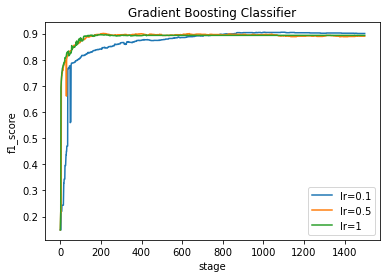

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt

# tune learning rate and n_estimator
all_lr = [0.1, 0.5, 1]
n_estimator = 1500

best_stage = []
best_f1 = []

for lr in all_lr:
    clf = GradientBoostingClassifier(n_estimators=n_estimator, learning_rate=lr).fit(x_train, y_train)
    print(f'finish fitting lr = {lr}')
    stages = list(range(n_estimator))
    f1_scores = [0] * n_estimator
    idx = 0
    for stage, y_pred in enumerate(clf.staged_predict(x_valid)):
        f1_scores[idx] = f1_score(y_valid, y_pred)
        idx += 1
    stages = np.array(stages)
    f1_scores = np.array(f1_scores)
    best_idx = np.argmax(f1_scores)
    best_stage.append(stages[best_idx])
    best_f1.append(f1_scores[best_idx])
    plt.plot(stages, f1_scores, label=f'lr={lr}')

for i in range(len(all_lr)):
    print(f'lr = {all_lr[i]}: best stage = {best_stage[i]}, best_f1_score = {best_f1[i]}')
plt.title('Gradient Boosting Classifier')
plt.xlabel('stage')
plt.ylabel('f1_score')    
plt.legend()
plt.show()

In [12]:
# train
best_f1 = np.array(best_f1)
best_idx = np.argmax(best_f1)
best_lr = all_lr[best_idx]
best_nstg = best_stage[best_idx]
print(f'best lr = {best_lr}, best_nstg = {best_nstg}')

best lr = 0.1, best_nstg = 1002


In [13]:
clf_gbdt = GradientBoostingClassifier(n_estimators=best_nstg, learning_rate=best_lr).fit(x_train_valid, y_train_valid)
y_pred = clf_gbdt.predict(x_test)
print(f'test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test precision: {precision_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')
print(f'test f1_score: {f1_score(y_test, y_pred)}')

test accuracy: 0.8665413533834586
test precision: 0.822429906542056
test recall: 0.9034907597535934
test f1_score: 0.8610567514677103


In [14]:
importance = clf_gbdt.feature_importances_
max20 = importance.argsort()[-20:]
print('20 features with max absolute coefficient:')
for idx in max20:
    print(x_test_col[idx], importance[idx])

20 features with max absolute coefficient:
庭 0.010108165751030268
慈 0.010148662080156226
瑄 0.010457835251262015
芷 0.010797252370754051
涵 0.011112311838953073
芸 0.011177614770121419
宜 0.011331339834406597
佳 0.011367081977882802
柔 0.011610906994878045
晴 0.011839408369194903
雅 0.012133938145565442
怡 0.01283586337557443
蓁 0.012839459689449965
承 0.012896883990426896
哲 0.012957391865331246
婷 0.01912972802235605
柏 0.019957782960591277
萱 0.020348411944513006
翔 0.02291578885362541
妤 0.030017040223587508


The accuracy, precision, recall, and f1-scores are all above 0.8. The prediction performs better than random forest.

The top 20 important features seems reasonable.

#### Q1.5

In [28]:
# get probability from base learners
prob_logitic = clf_log.predict_proba(x_stack)[:, 1].reshape((-1, 1))
prob_rand_forest = clf_randf.predict_proba(x_stack)[:, 1].reshape((-1, 1))
prob_gbdt = clf_gbdt.predict_proba(x_stack)[:, 1].reshape((-1, 1))
print(prob_logitic.shape, prob_rand_forest.shape, prob_gbdt.shape)
x_stack_meta = np.concatenate((prob_logitic, prob_rand_forest, prob_gbdt), axis=1)
print(f'x_stack_meta shape = {x_stack_meta.shape}')

(1073, 1) (1073, 1) (1073, 1)
x_stack_meta shape = (1073, 3)


In [33]:
# meta learner
clf_meta = LogisticRegression(penalty='none').fit(x_stack_meta, y_stack)
test_prob_logitic = clf_log.predict_proba(x_test)[:, 1].reshape((-1, 1))
test_prob_rand_forest = clf_randf.predict_proba(x_test)[:, 1].reshape((-1, 1))
test_prob_gbdt = clf_gbdt.predict_proba(x_test)[:, 1].reshape((-1, 1))
x_test_meta = np.concatenate((test_prob_logitic, test_prob_rand_forest, test_prob_gbdt), axis=1)
print(f'x_test_meta shape = {x_test_meta.shape}')

y_pred = clf_meta.predict(x_test_meta)

print(f'test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test precision: {precision_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')
print(f'test f1_score: {f1_score(y_test, y_pred)}')

x_test_meta shape = (1064, 3)
test accuracy: 0.8834586466165414
test precision: 0.8579881656804734
test recall: 0.893223819301848
test f1_score: 0.8752515090543259


In [35]:
# coefficient
meta_coef = clf_meta.coef_
print(meta_coef)

[[ 3.03596275 -0.39242928  5.50754097]]


The coefficient for probability from the logistic regression model, the random forest model, and the gradient boosting decision tree model are 3.036, -0.392, and 5.508, respectively.

Note that the coefficient for probability from the gradient boosting decision tree is the largest. Meanwhile, it is the model that predicts the most accurately when standing alone.

### Q2

In [133]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('./ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('./ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

In raw data, there are 60461 students and 1976 departments in total.


In [134]:
# construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    dep_stu[dep_seq, stu_seq] = 1

In [135]:
# remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

# remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

# another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

# third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

# check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

# now both conditions are satisfied.

Number of department too small: 0
Number of students applying only one department: 0


In [136]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
# this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
uname2['category_id'] = category_id

# create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [137]:
print('---------- dep_stu2 ----------')
print(dep_stu2)
print(dep_stu2.shape)

print('---------- uname2 ----------')
print(uname2)

print('---------- category_id ----------')
print(category_id, category_id.shape)

print('---------- category_levels ---------- ')
print(list(category_levels))

print('---------- colname_df ---------- ')
print(colname_df)

---------- dep_stu2 ----------
[[1. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]
(1917, 47386)
---------- uname2 ----------
     department_id    depname category_name  category_id
0           006042       政大教育            教育            0
1           006052    政大教育(公)            教育            0
2           006062  政大教育(原住民)            教育            0
3           006022       政大歷史         藝術及人文            1
4           006152      政大民族學         藝術及人文            1
...            ...        ...           ...          ...
1996        099212      臺北飛鳶組            其他            8
1997        108182  慈濟不分系(新A)            其他            8
1998        108192  慈濟不分系(新B)            其他            8
1999        108202  慈濟不分系(新C)            其他            8
2000        112062   康寧企管(臺南)            其他            8

[2001 rows x 4 columns]
---------- category_id ----------
[0 0 0 ... 8 8 8] (2001,)
-

#### Q2.1: PCA

In [138]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
pca.fit(dep_stu2)
print(pca)

PCA(n_components=8)


In [139]:
projected = pca.fit_transform(dep_stu2)
print(f'projected shape = {projected.shape}')

projected shape = (1917, 8)


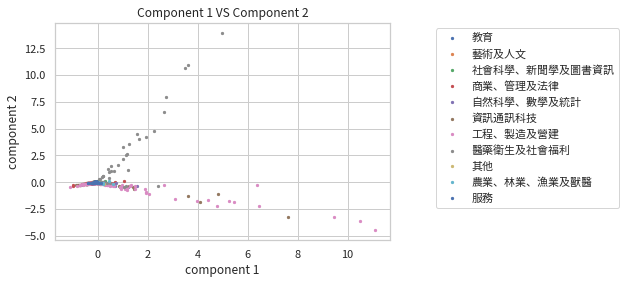

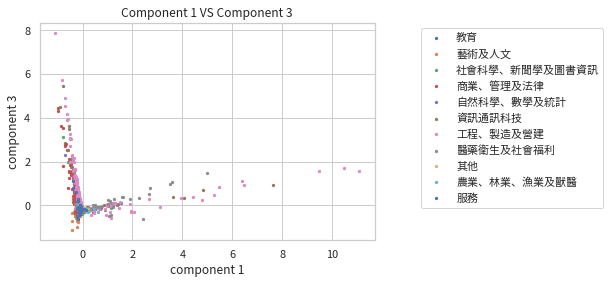

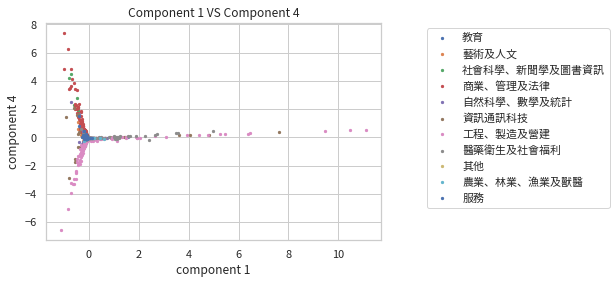

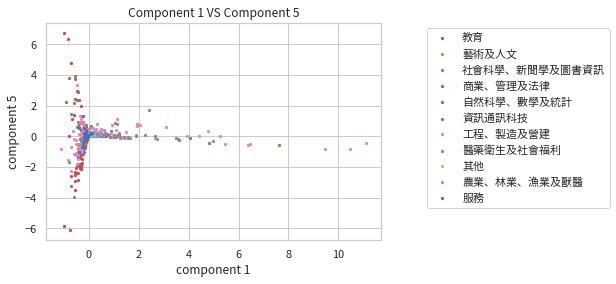

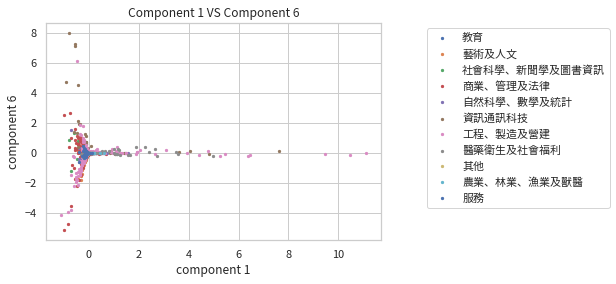

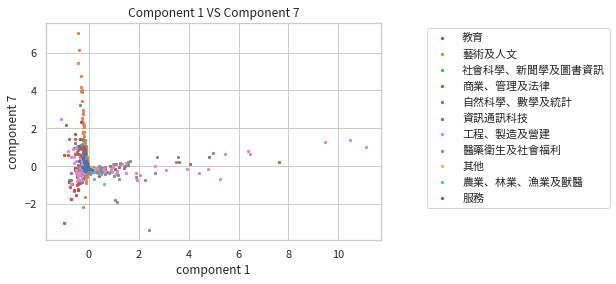

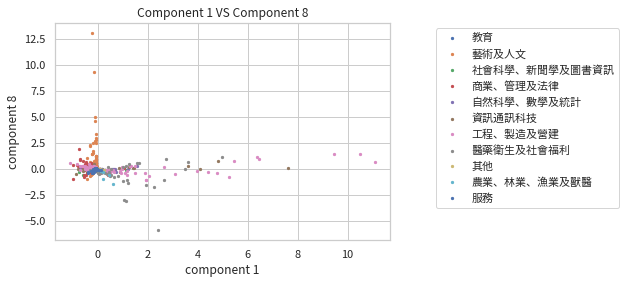

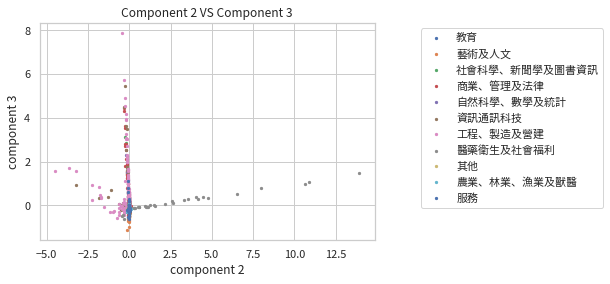

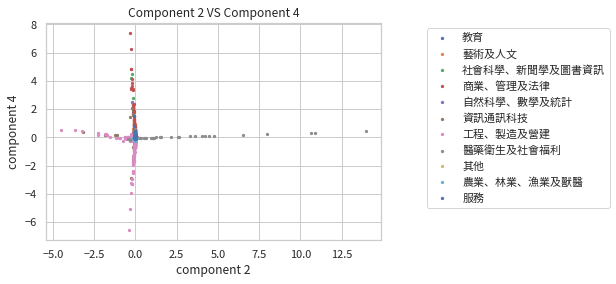

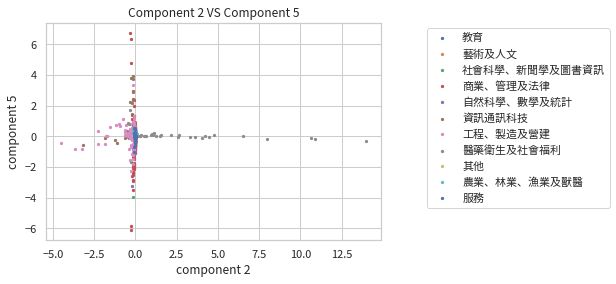

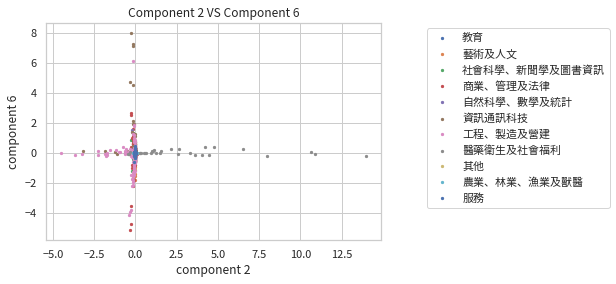

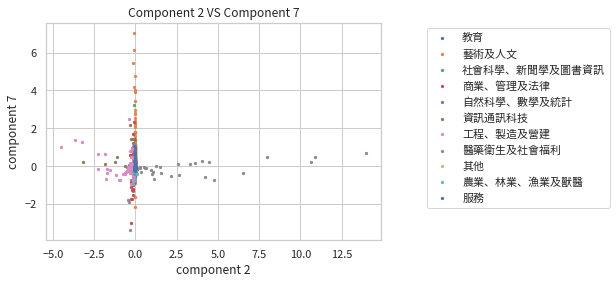

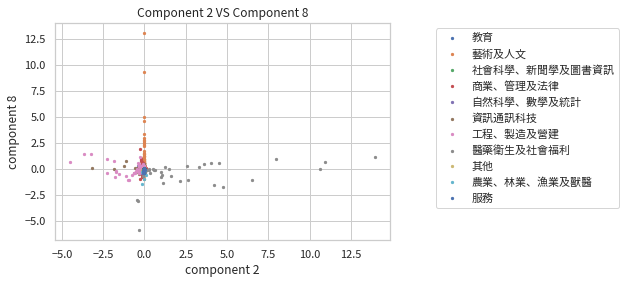

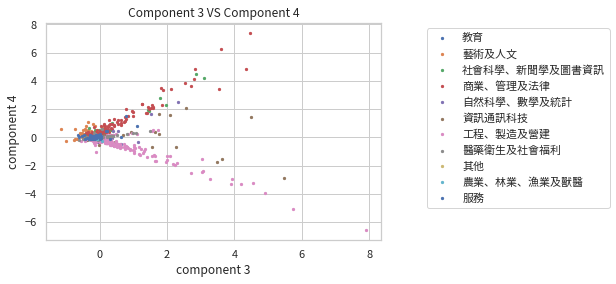

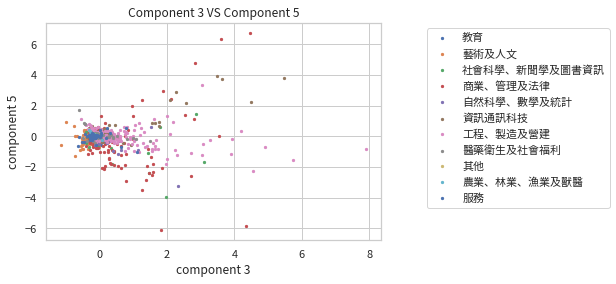

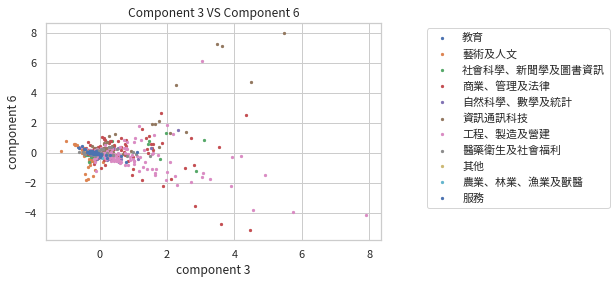

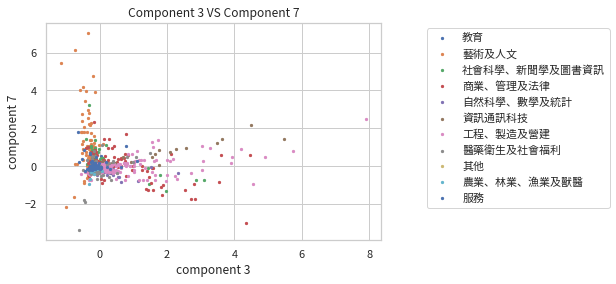

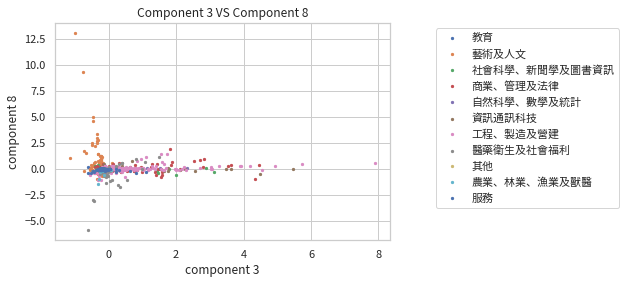

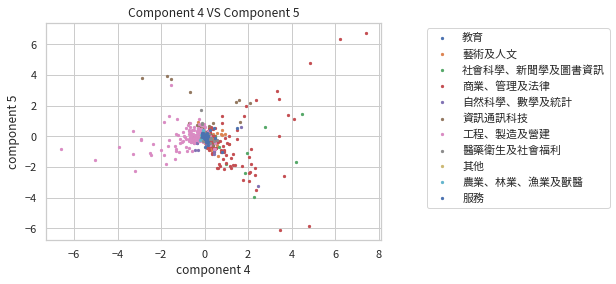

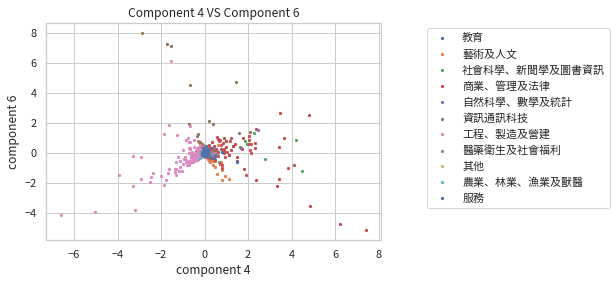

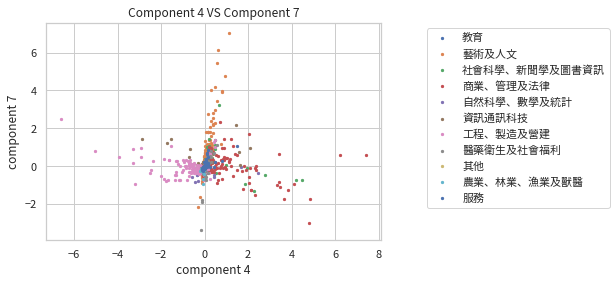

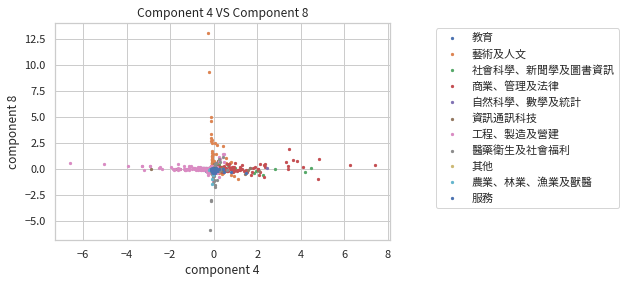

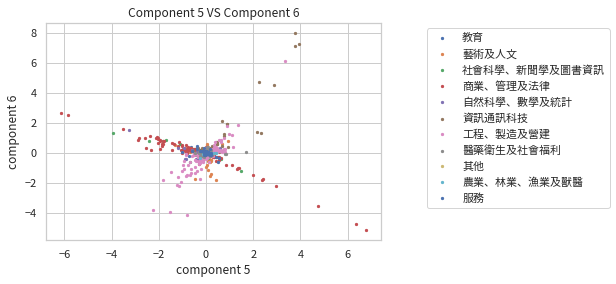

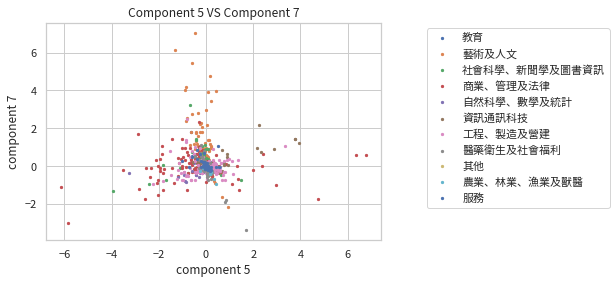

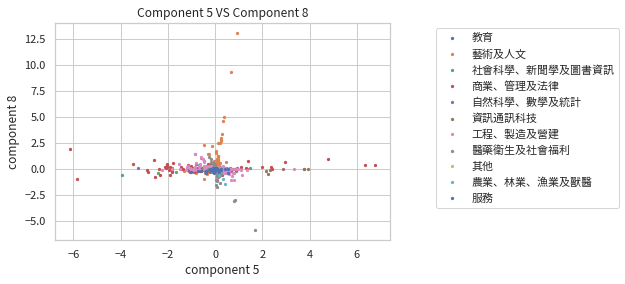

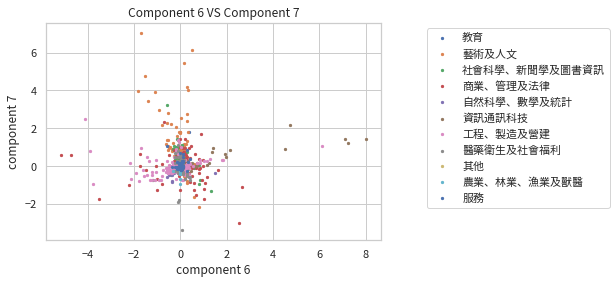

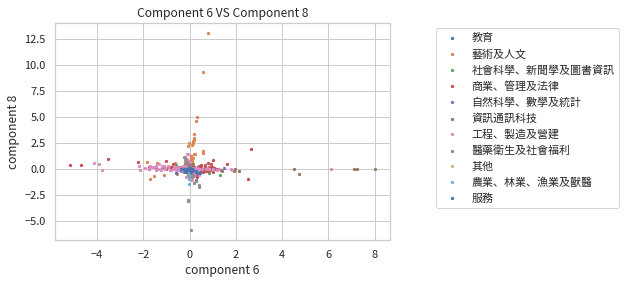

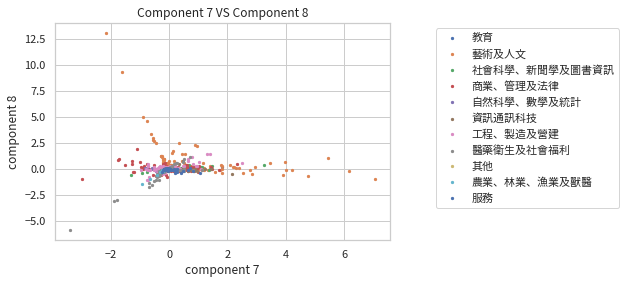

In [140]:
from matplotlib import pyplot as plt
from itertools import combinations

plt.rcParams['font.family'] = ['Noto Sans CJK JP']
category = colname_df['category_id'].to_numpy()

for (i, j) in combinations(list(range(8)), 2):
    for c in set(category):
        x = projected[(category == c), i]
        y = projected[(category == c), j]
        plt.scatter(x, y, label=category_levels[c], s=5)
        plt.title(f'Component {i+1} VS Component {j+1}')
        plt.xlabel(f'component {i+1}')
        plt.ylabel(f'component {j+1}')
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))
    plt.show()

The PCA results did not seperate the 8 categories well.

It is surprising that the first two principle component is not the best pair when it comes to visualizing the data.

In this case, component 3 and 4 appeared to perform better.

#### Q2.2: Multiple Dimension Scaling

In [57]:
from sklearn.manifold import MDS

# metric MDS
metric_mds = MDS(n_components=2, metric=True)
metric_projected = metric_mds.fit_transform(dep_stu2)
print(metric_projected.shape)

(1917, 2)


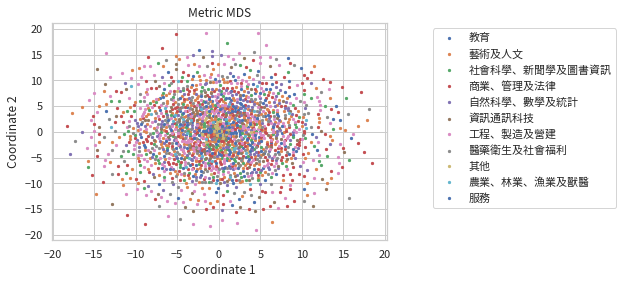

In [142]:
for c in set(category):
    x = metric_projected[(category == c), 0]
    y = metric_projected[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'Metric MDS')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

In [143]:
# non-metric MDS
non_metric_mds = MDS(n_components=2, metric=False)
non_metric_projected = non_metric_mds.fit_transform(dep_stu2)
print(non_metric_projected.shape)

(1917, 2)


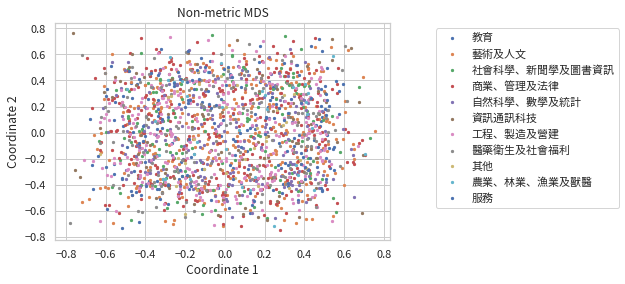

In [144]:
for c in set(category):
    x = non_metric_projected[(category == c), 0]
    y = non_metric_projected[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'Non-metric MDS')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

Both metrix MDS and non-metric MDS do not perform well on seperating the categories.

It is notable that metric scaling, whose distance respect triangular inequality, results data points in a circular matter in this case.

#### Q2.3: Locally Linear Embedding

**10 Neighbors**

In [68]:
from sklearn.manifold import LocallyLinearEmbedding

# n_neighbors = 10
lle_10 = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
proj_lle10 = lle_10.fit_transform(dep_stu2)
print(proj_lle10.shape)

(1917, 2)


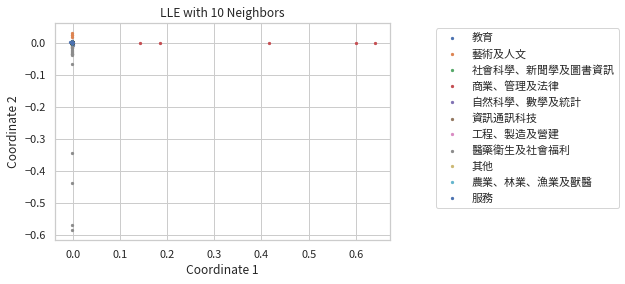

In [145]:
for c in set(category):
    x = proj_lle10[(category == c), 0]
    y = proj_lle10[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'LLE with 10 Neighbors')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

**15 Neighbors**

In [70]:
# n_neighbors = 15
lle_15 = LocallyLinearEmbedding(n_neighbors=15, n_components=2)
proj_lle15 = lle_15.fit_transform(dep_stu2)
print(proj_lle15.shape)

(1917, 2)


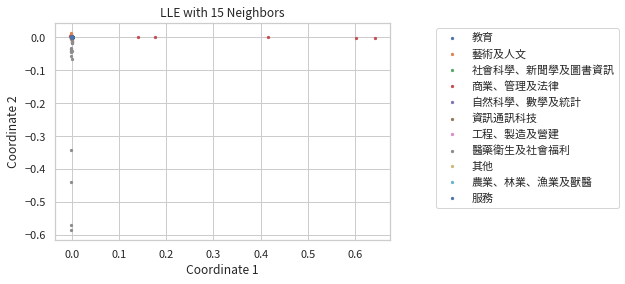

In [147]:
for c in set(category):
    x = proj_lle15[(category == c), 0]
    y = proj_lle15[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'LLE with 15 Neighbors')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

First 100 PC from PCA, then LLE with **10 neighbors**

In [72]:
pca100 = PCA(n_components=100)
pca100.fit(dep_stu2)
projected_100 = pca100.fit_transform(dep_stu2)
print(projected_100.shape)

(1917, 100)


In [73]:
pca_lle_10 = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
proj_pca_lle10 = pca_lle_10.fit_transform(dep_stu2)
print(proj_pca_lle10.shape)

(1917, 2)


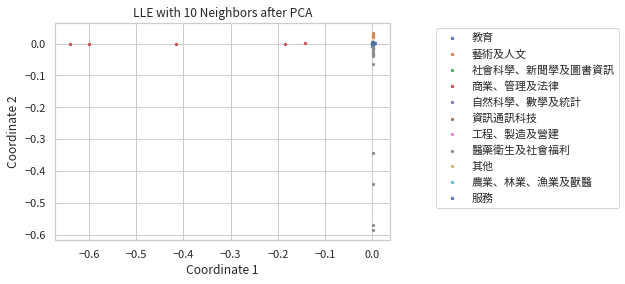

In [148]:
for c in set(category):
    x = proj_pca_lle10[(category == c), 0]
    y = proj_pca_lle10[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'LLE with 10 Neighbors after PCA')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

All 3 LLE models do not perform well on seperating data points of different categories.

Note that by applying PCA and select the first 100 PCs, the result of the LLE model seems to flip on the first coordinate.

#### Q2.4: Kernel PCA

RBF kernel

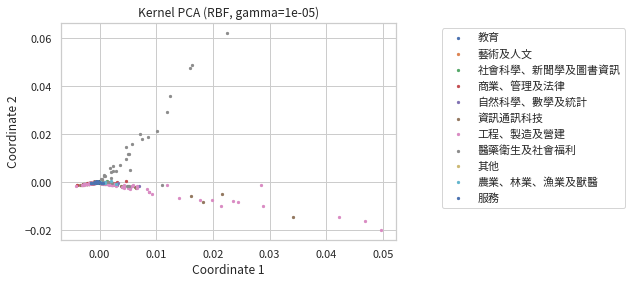

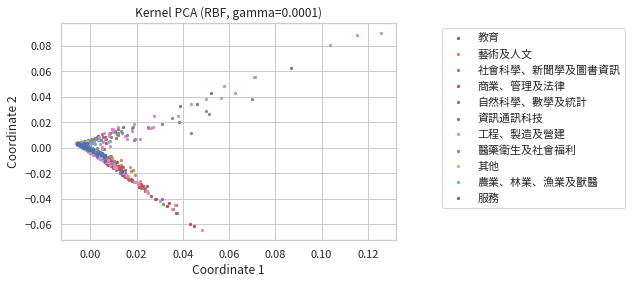

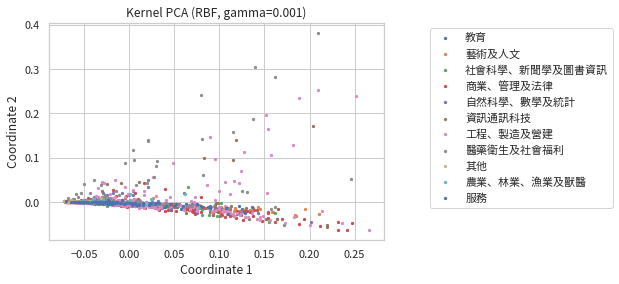

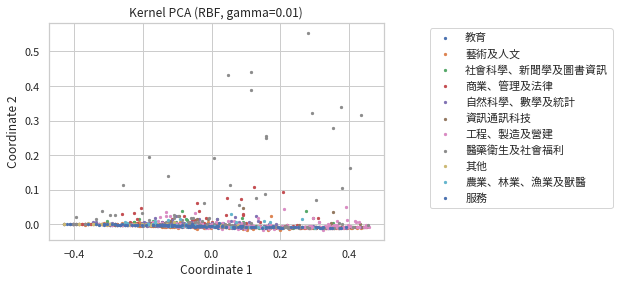

<Figure size 432x288 with 0 Axes>

In [149]:
from sklearn.decomposition import KernelPCA

all_gamma = [0.00001, 0.0001, 0.001, 0.01]
for g in all_gamma:
    rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=g)
    proj_rbf = rbf_pca.fit_transform(dep_stu2)
    
    for c in set(category):
        x = proj_rbf[(category == c), 0]
        y = proj_rbf[(category == c), 1]
        plt.scatter(x, y, label=category_levels[c], s=5)
        plt.title(f'Kernel PCA (RBF, gamma={g})')
        plt.xlabel(f'Coordinate 1')
        plt.ylabel(f'Coordinate 2')
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))
    plt.show()
    plt.clf()

Cosine kernel

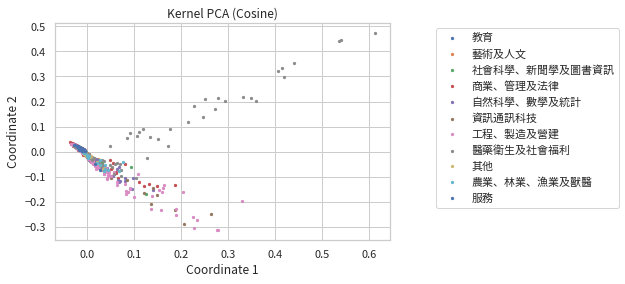

In [151]:
cos_pca = KernelPCA(n_components=2, kernel='cosine', gamma=g)
proj_cos = cos_pca.fit_transform(dep_stu2)

for c in set(category):
    x = proj_cos[(category == c), 0]
    y = proj_cos[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'Kernel PCA (Cosine)')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

Both kernel PCA kernels result in V-shape scattered data. However, categories are not well seperated.

#### Q2.5

In [85]:
np.random.seed(0)

Euclidian

In [88]:
from sklearn.manifold import TSNE

tsne_eucl = TSNE(n_components=2, metric='euclidean')
proj_tsne_eucl = tsne_eucl.fit_transform(dep_stu2)
print(proj_tsne_eucl.shape)

(1917, 2)


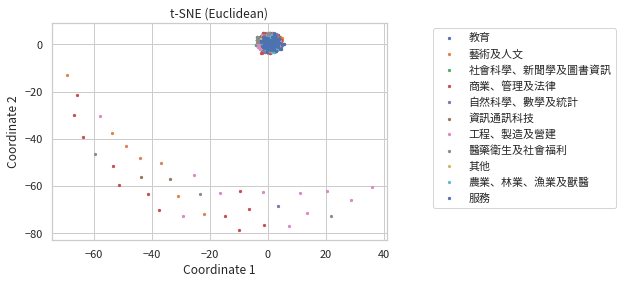

In [153]:
for c in set(category):
    x = proj_tsne_eucl[(category == c), 0]
    y = proj_tsne_eucl[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f't-SNE (Euclidean)')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

Cosine

In [90]:
tsne_cos = TSNE(n_components=2, metric='cosine')
proj_tsne_cos = tsne_cos.fit_transform(dep_stu2)
print(proj_tsne_cos.shape)

(1917, 2)


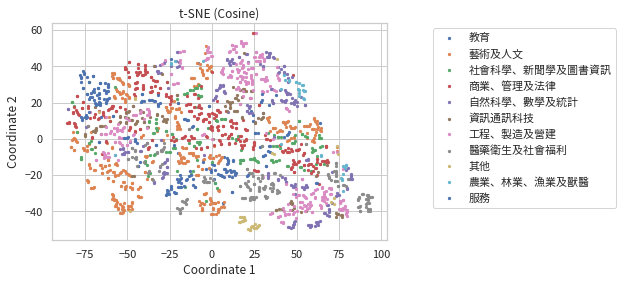

In [155]:
for c in set(category):
    x = proj_tsne_cos[(category == c), 0]
    y = proj_tsne_cos[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f't-SNE (Cosine)')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

Jaccard

In [92]:
tsne_jac = TSNE(n_components=2, metric='jaccard')
proj_tsne_jac = tsne_jac.fit_transform(dep_stu2)
print(proj_tsne_jac.shape)

(1917, 2)


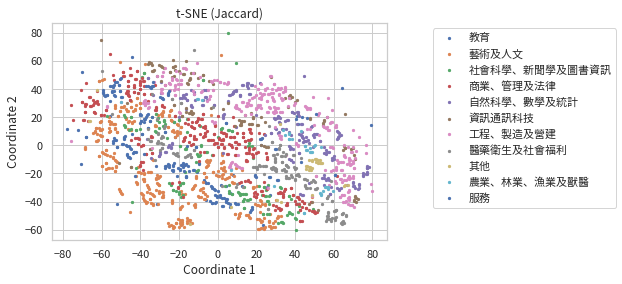

In [156]:
for c in set(category):
    x = proj_tsne_jac[(category == c), 0]
    y = proj_tsne_jac[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f't-SNE (Jaccard)')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

t-SNE models with Cosine and Jaccard metric show several clusters. These models perform much better then previous ones.

#### Q2.6

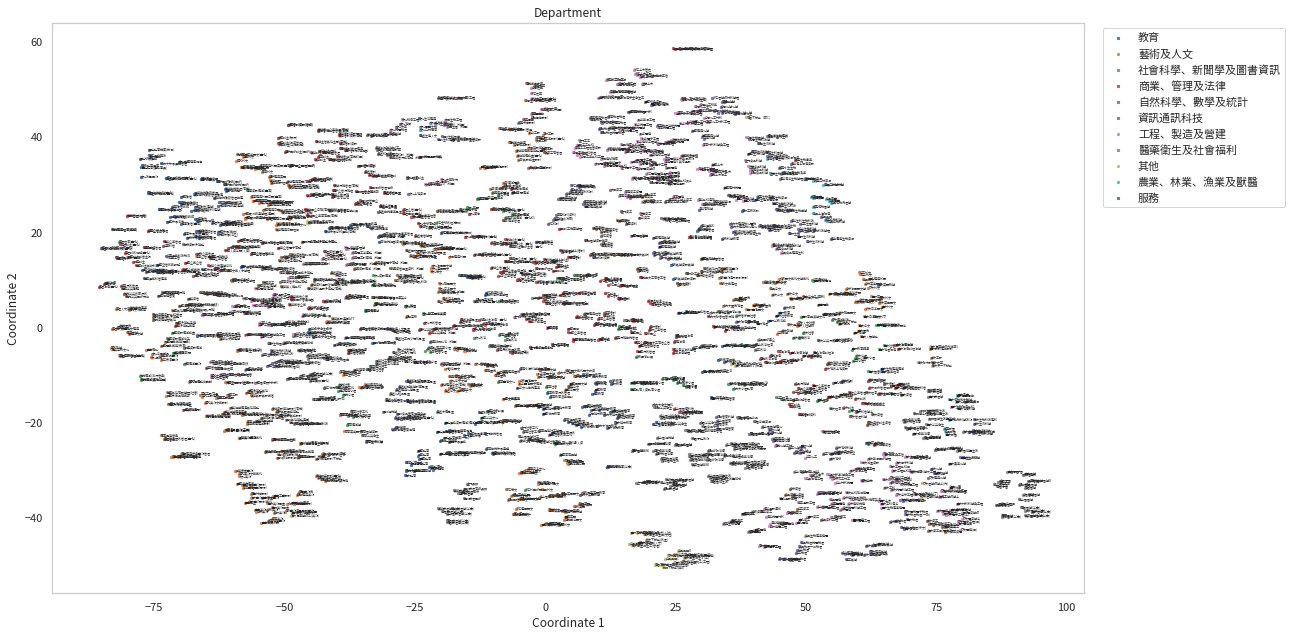

In [178]:
plt.rcParams['font.family'] = ['Noto Sans CJK JP']
plt.rcParams['font.size'] = 3
dep = colname_df['depname'].to_numpy()
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

for c in set(category):
    x = proj_tsne_cos[(category == c), 0]
    y = proj_tsne_cos[(category == c), 1]
    plt.scatter(x, y, label=category_levels[c], s=5)
    plt.title(f'Department')
    plt.xlabel(f'Coordinate 1')
    plt.ylabel(f'Coordinate 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    for i, txt in enumerate(dep[(category == c)]):
        plt.annotate(txt, (x[i], y[i]))

fig.savefig('Q2_6.png', dpi=1080)